In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import matplotlib.pyplot as plt

# Get data and process it into batches

In [26]:
IMAGE_SIZE = (28, 28)
BATCH_SIZE = 100

# Import data
data = pd.read_csv(r"../digit-recognizer/train.csv")
data_test = pd.read_csv(r"../digit-recognizer/test.csv")    

# Get labels and image array from data
labels : np.ndarray = data.values[:, 0]
images : np.ndarray = data.values[:, 1:].astype('uint8')

images_test : np.ndarray = data_test.values.astype('uint8')

image_batches = torch.from_numpy(np.reshape(images / 255, (images.shape[0] // BATCH_SIZE, BATCH_SIZE) + (1, ) + IMAGE_SIZE).astype(np.float32))
label_batches = torch.from_numpy(np.reshape(labels, (labels.shape[0] // BATCH_SIZE, BATCH_SIZE)))
print(image_batches.shape)
print(label_batches.shape)

torch.Size([420, 100, 1, 28, 28])
torch.Size([420, 100])


# CNN with softmax activation

In [22]:
class CNNSoftmax(nn.Module):
    def __init__(self, input_channel: int, input_size: int, output: int):
        super().__init__()

        # ========== CONVOLUTION AND POOLING ============
        # Max pooling with 2x2 kernel, stride=2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # RelU as activation function
        self.relu = nn.ReLU()

        # Convolution output size formula:
        #   ((curr_size + 2*padding - kernel_size) / stride) + 1
        
        # 28 x 28
        self.conv1 = nn.Conv2d(input_channel, 5, 3, stride=1, padding=0)
        
        # conv with kernel = 3, stride = 1, and padding = 0
        #   curr_size - kernel + 1 = 28 - 3 + 1 = 26x26
        input_size = input_size - 3 + 1

        # max pool 2x2 w/ stride=2 (padding must be 0)
        #   (curr_size - kernel) / stride + 1 = (26 - 2) / 2 + 1 = 13x13
        input_size = (input_size - 2) // 2 + 1
        
        # 13x13
        self.conv2 = nn.Conv2d(5, 10, 3, stride=1, padding=0)
        
        # conv with kernel = 3, stride = 1, and padding = 0
        #   curr_size - kernel + 1 = 13 - 3 + 1 = 11x11
        input_size = input_size - 3 + 1

        # max pool 2x2 w/ stride=2 (padding must be 0)
        #   (curr_size - kernel) / stride + 1 = (11 - 2) / 2 + 1 = 5.5x5.5 = 5x5 (floor)
        input_size = (input_size - 2) // 2 + 1

        # ========== CLASSIFICATION ==========
        # 10channel x 5x5 nodes as input
        self.flatten_size = input_size
        self.linear1 = nn.Linear(10*(input_size**2), 256)

        # 10 types of category (0-9) as output
        self.linear2 = nn.Linear(256, output)

    def forward(self, x: torch.Tensor):
        # Convolution phase
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        
        # Flatten x to fully connect the channels
        x = torch.flatten(x, start_dim=1)
        
        # Classification phase
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))

        return x

# Training

Epoch: 1 --> Wrong: 37409, Accuracy: 10.930952380952391%



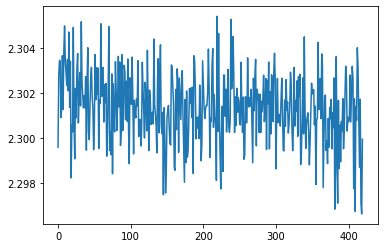

KeyboardInterrupt: 

In [27]:
EPOCH = 100
# When weights become NaN, try reducing the learning rate
LEARNING_RATE = 0.001

model = CNNSoftmax(1, 28, 10)
optimizer = optim.SGD(model.parameters(), LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

total_loss = []

for e in range(EPOCH):
    epoch_loss = []
    for j, batch in enumerate(image_batches):
        optimizer.zero_grad()
        res = model(batch)
        # print(batch.shape)
        # print(res.shape)
        # print(label_batches[j].shape)

        # print(res, label_batches[j])
        loss : torch.Tensor = criterion(res, label_batches[j])
        epoch_loss.append(loss.item())
        
        # prev_w : torch.Tens   or
        # prev_w.copy_(model.linear1.weight)
        loss.backward()
        optimizer.step()

        # prev_w = prev_w - model.linear1.weight
        # for node_w in prev_w:
        #     for w in node_w:
        #         if w.item() != 0:
        #             print(w)
        
        # print("EY")

    wrong = 0
    for j, image in enumerate(images):
        image = torch.from_numpy((image).astype(np.float32))
        res = model(image.reshape((1, 1) + IMAGE_SIZE))
        res = torch.softmax(res, 1)
        pred = res.argmax()
        wrong += (pred.item() != labels[j])
    print(f"Epoch: {e+1} --> Wrong: {wrong}, Accuracy: {100-wrong / labels.size * 100}%\n")           
    
    total_loss.append(epoch_loss)
    plt.plot(epoch_loss)
    plt.show()
    # print(epoch_loss)

plt.plot(total_loss)
plt.show()